<a href="https://colab.research.google.com/github/tejas20/CGAN-Covid19-SyntheticImageGeneration/blob/main/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to CNN Keras - Acc 0.993 (top 10%)**

1. Introduction
2. Data preparation
    
    2.1 Load data
    
    2.2 Check for null and missing values

    2.3 Label encoding

    2.4 Reshape
    
    2.5 Normalization and Data augmentation
    
    2.6 Split training and valdiation set

    2.7 Passing the Train dataset to the ImageDataGenerator
3. CNN

    3.1 Define the model

    3.2 Set the optimizer and annealer
    
4. Evaluate the model

    4.1 Training and validation curves

    4.2. Evaluating the Model
    
    4.3 Confusion matrix
5. Prediction and submition

    5.1 Predict and Submit results


# **1. Introduction**

This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.

For computational reasons, i set the number of steps (epochs) to 2, if you want to achieve 99+% of accuracy set it to 30.

This Notebook follows three main parts:

*   The data preparation
*   The CNN modeling and evaluation
*   The results prediction and submission

In [ ]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing all the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical #import categorical from keras.utils library
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.densenet import preprocess_input
import matplotlib.pyplot as plt 
from keras.metrics import Recall,Precision
from sklearn.metrics import confusion_matrix
import itertools

from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# **2. Data preparation**
   
>## **2.1 Load data**

In [ ]:
#using pandas to read the csv file and save it in dataframe
sample_submission_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/sample_submission.csv')
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/test.csv')


In [ ]:
#printing the head of dataframe
sample_submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
#printing the train data head to check values
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#lets check for the maximum value in the columns
train_df.to_numpy().max()

255

In [ ]:
#check the info of the dataframe which will include total number of columns, data size and label information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


>## **2.2 Check for null and missing values**

In [ ]:
#check for any null values in the column
train_df.isnull().values.any()

False

In [ ]:
#lets check for the shape of our train dataset
train_df.shape

(42000, 785)

> ## **2.3 Label encoding**

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

In [ ]:
#extract the labels from the data and convert it to categorical data
train_labels = np.asarray(train_df['label']);
train_labels = to_categorical(train_labels);

In [ ]:
train_labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

> ## **2.4 Reshape**

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [ ]:
#Drop the labels from the train dataset and shape it in 28x28 size
train_data = train_df.drop('label', axis=1)
train_data = np.asarray(train_data).reshape(train_data.shape[0], 28, 28, 1)

> ## **2.5 Normalization**

We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].


*Keras ImageDataGenerator is a gem! It lets you augment your images in real-time while your model is still training! You can apply any random transformations on each training image as it is passed to the model. This will not only make your model robust but will also save up on the overhead memory.*

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important :

>Without data augmentation i obtained an accuracy of 98.114%

>With data augmentation i achieved 99.353% of accuracy

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,  #rescaling the images 
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        fill_mode='constant', #keep the fill_mode to constant
        vertical_flip=False)  # randomly flip images


validation_datagen = ImageDataGenerator(rescale=1./255)

For the data augmentation, i choosed to :

* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height
* I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

> ## **2.6 Split training and valdiation set**

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

To avoid that, you could use stratify = True option in train_test_split function (Only for >=0.17 sklearn versions).

We can get a better sense for one of these examples by visualising the image and looking at the label.

In [ ]:
train_images, validation_images, train_labels, validation_labels = 
                      train_test_split(train_data, train_labels, test_size=0.3, random_state=40)

> ## **2.7 Passing the Train dataset to the ImageDataGenerator**

In [ ]:
train_generator = datagen.flow(train_images, train_labels, batch_size=256)
validation_generator = validation_datagen.flow(validation_images, validation_labels, batch_size=256)

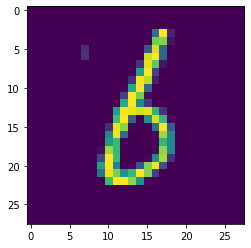

In [ ]:
# Some examples
g = plt.imshow(train_images[0][:,:,0])

# **3**. **CNN**    
> ## **3.1 Define the model**


I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
model=Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [ ]:
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

# Lets save our Model to a PNG file 

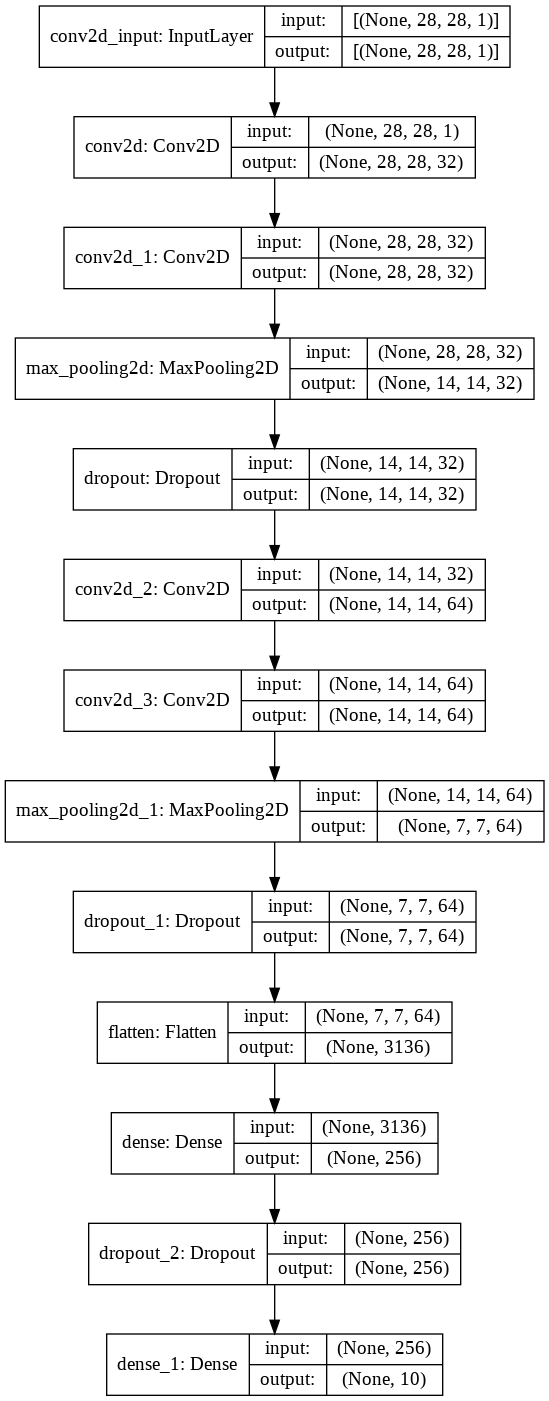

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=720, height=1600)

# **3.2 Set the optimizer and annealer**

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [ ]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
# Model Compile 
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy',Precision(),Recall()],
              optimizer=optimizer)

# **4. Evaluate the model**
>## **4.1 Training and validation curves**

I have used EarlyStopping and ModelChecking for value accuracy and eleminating the model run when the learning accuracy is not improving for more than 14 epoch

In [ ]:
# Defining Callbacks
filepath = './best_weights.hdf5'
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
#lets set train our model
model_history=model.fit(train_generator, 
                        steps_per_epoch=100, 
                        epochs=40, 
                        validation_data=validation_generator, 
                        validation_steps=50, 
                        callbacks = callback_list,
                        verbose=1)

Epoch 1/40
100/100 [==============================] - 16s 84ms/step - loss: 0.7802 - accuracy: 0.7407 - precision: 0.7746 - recall: 0.3996 - val_loss: 0.1066 - val_accuracy: 0.9680 - val_precision: 0.8998 - val_recall: 0.7109

Epoch 00001: val_accuracy improved from -inf to 0.96802, saving model to ./best_weights.hdf5
Epoch 2/40
100/100 [==============================] - 7s 71ms/step - loss: 0.2222 - accuracy: 0.9332 - precision: 0.9230 - recall: 0.7908 - val_loss: 0.0639 - val_accuracy: 0.9805 - val_precision: 0.9352 - val_recall: 0.8342

Epoch 00002: val_accuracy improved from 0.96802 to 0.98048, saving model to ./best_weights.hdf5
Epoch 3/40
100/100 [==============================] - 7s 70ms/step - loss: 0.1520 - accuracy: 0.9543 - precision: 0.9427 - recall: 0.8595 - val_loss: 0.0541 - val_accuracy: 0.9840 - val_precision: 0.9482 - val_recall: 0.8778

Epoch 00003: val_accuracy improved from 0.98048 to 0.98405, saving model to ./best_weights.hdf5
Epoch 4/40
100/100 [================

>## **4.2. Evaluating the Model**

Here I have used model metrices - Accuracy, Loss, Precision and recall to check the models performance and plot the graph of the respective metrics

In [ ]:
model.metrics_names

['loss', 'accuracy', 'precision', 'recall']

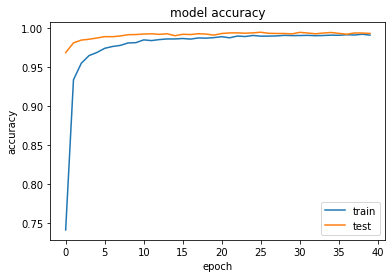

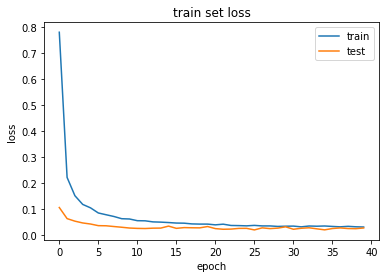

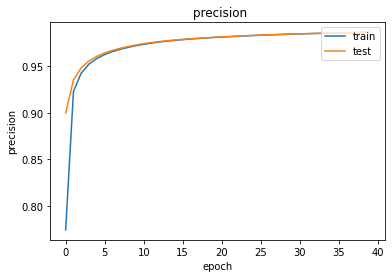

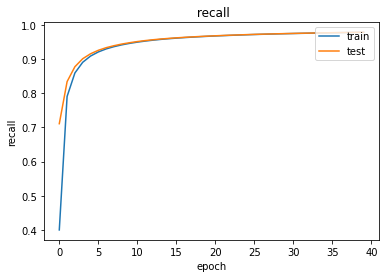

In [ ]:
#Potting the Accuracy, Loss, Precision and recall
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
print('\n')

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('train set loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
print('\n')
model.metrics_names

plt.plot(model_history.history['precision'])
plt.plot(model_history.history['val_precision'])
plt.title(' precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
print('\n')

plt.plot(model_history.history['recall'])
plt.plot(model_history.history['val_recall'])
plt.title(' recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
#evaluating the model accuracy, precision, recall and loss
loss, acc, precision, recall = model.evaluate(validation_generator)
print('validation Accuracy: %.3f' % acc)
print('validation Precision: %.3f' % precision)
print('validation Recall: %.3f' % recall)
print('validation loss: %.3f' % loss)

50/50 [==============================] - 0s 9ms/step - loss: 0.0280 - accuracy: 0.9926 - precision: 0.9863 - recall: 0.9790
validation Accuracy: 0.993
validation Precision: 0.986
validation Recall: 0.979
validation loss: 0.028


# **4.3 Confusion matrix**
Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

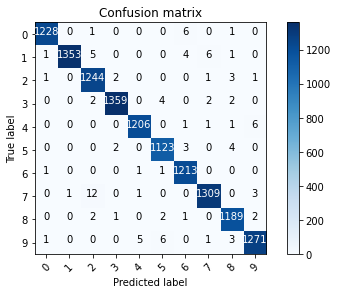

In [ ]:
# Look at confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(validation_images)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(validation_labels,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the 4 digits, they are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors.

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

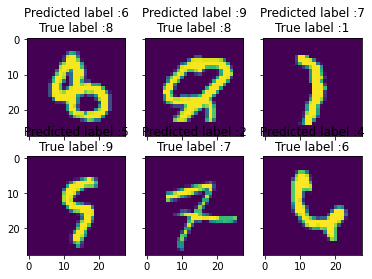

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = validation_images[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The most important errors are also the most intrigous.

For those six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 5. The last 6 is also very misleading, it seems for me that it is a 4.



In [ ]:
#Save the model
model.save('./best_weights.hdf5')

# **5. Prediction and submition**

> ## 5.1 Predict and Submit results

In [ ]:
test_images = np.asarray(test_df)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
test_images = test_images.astype('float32')/255

In [ ]:
predictions = model.predict(test_images, batch_size=128)
image_id = range(1, predictions.shape[0] + 1)

In [ ]:
pred = [np.argmax(i) for i in predictions]

In [ ]:
data = {'ImageId':image_id,'Label':pred}
df = pd.DataFrame(data)

In [ ]:
df.to_csv(path_or_buf='/content/drive/MyDrive/Colab Notebooks/Projects/submission.csv', index=False)